# Hamiltonian Monte Carlo algorithm

In this notebook, I shall implement Hamiltonian Monte Carlo algorithm (HMC), a MCMC algorithm using Hamiltonian dynamics to propose a point, which is distant from the current point yet with low rejection probability.


In [1]:
import numpy as np
import random 
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1 Theory

## 1.1 Setting

* Let us assume that the variable of interest resides in $\mathbb{R}^d$, with $d \in \mathbb{N}$ being the dimension. 
* Let $\pi_Q$ be a probability distribution over $\mathbb{R}^d$, from which we want to sample. It is assumed that $\pi_Q$ can be expressed as $\pi_Q = \frac{1}{Z_Q} \tilde{\pi}_Q$ with constant $Z_Q$ and a unnormalized distribution $\tilde{\pi}_Q$, where $\tilde{\pi}_Q$ can be evaluated easily.
* Let us define $U(q) := - \log \tilde{\pi}_Q(q)$, and assume that it is differentiable with respect to $q$.
* For simplicity, we shall assume that the $\pi_Q$ is everywhere non-zero, so that $U$ is defined everywhere on $Q$. (If there exists a region on which $\pi_Q = 0$ holds, then ergodicity might break. In my intuition, assuming that the region $\left\{ q \in \mathbb{R}^d | \pi_Q(q) > 0 \right\}$ is singly connected may suffices, but I have not verified it.)


## 1.2 Introducing the momentum variable

Let us introduce 

* an auxiliary variable, which shall be called "momentum", $p \in \mathbb{R}^d$, and
* a probability distribution $\pi_P(p) \propto e^{-K(p)}$ over $\mathbb{R}^d$, where $K$ is even in the sense that $K(p) = K(-p)$ holds for all $p \in \mathbb{R}^d$. (Later, we take $K(p) = \frac{1}{2} p^T p$.) It is assumeed that $\pi_P$ can be easily sampled. 

Let us define the Hamiltonian $H$ by $H(q,p) = K(p) + U(q)$.

Under these definitions, consider sampling from the joint probability distribution $\pi_{Q, P}(q, p) = \pi_Q(q) \pi_P(p)$. 
It is clear that marginalizing the distribution with respect to $p$ will immediately give us $\pi_Q$, our target distribution. Put differently, if we sample from the joint distribution and simply dispose $p$ components, then we get samples of $q$ which follows $\pi_Q$.

Also, it should be noted that $\pi_{Q, P}(q, p) \propto \exp[-H(q, p)] =: \tilde{\pi}_{Q, P}(q, p)$

## 1.3 Recap of Metropolis-Hastings algorithm

The idea of HMC is to use a deterministic dynamics to propose the next point in Metropolis-Hastings algorithm.
Thus, here we quickly go through Metropolis-Hastings algorithm applied to the current problem.

In the Metroopolis-Hastings algorithm, a single update step (which shall be called Metropolis-Hastings update) proceeds as follows (denote the current point by $(q_{\rm current}, p_{\rm current})$):  
1. a point $(q_{\rm tmp}, p_{\rm tmp})$ is proposed according to a given proposal distribution $\rho(q_{\rm tmp}, p_{\rm tmp} | q_{\rm current}, p_{\rm current})$.
2. The next point $(q_{\rm next}, p_{\rm next})$ is determined by

$$
\begin{align}
    (q_{\rm next}, p_{\rm next}) = \begin{cases}
        (q_{\rm tmp}, p_{\rm tmp}) &  (\mbox{ with probability  } A((q_{\rm tmp}, p_{\rm tmp}), (q_{\rm current}, p_{\rm current} )) \ )\\
        (q_{\rm current}, p_{\rm current}) & (\mbox{ with probability } 1 - A((q_{\rm tmp}, p_{\rm tmp}), (q_{\rm current}, p_{\rm current}) ) \ )
    \end{cases}
\end{align}
$$

where 

$$
\begin{align}
    A((q', p')| (q, p) ) := \min \left( 1, \frac{\tilde{\pi}_{Q, P}(q', p')}{\tilde{\pi}_{Q, P}(q, p)} \cdot \frac{\rho(q, p| q', p')}{\rho(q', p' | q, p)}  \right)
\end{align}
$$

In the former case, we say the proposed point $(q_{\rm tmp}, p_{\rm tmp})$ is accepted, while in the latter case it is said to be rejected.


## 1.4 Metropolis-Hastings update with deterministic transitions

Let us consider a deterministic transition defined by $f : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d $ as our proposal distribution:

$$
\begin{align}
    \rho(q, p | q', p') = \delta((q, p) - f(q', p')), 
\end{align}
$$
where $\delta$ stands for the delta fucnction. (NOTE : Here all the mathematical subtleties related to the delta function are neglected.)

Assuming
1. $f$ is invertible and $f^{-1} = f$, and
2. $f$ has unit Jacobian, 

it can be shown that, 

$$
\begin{align}
    A((q', p')| (q, p) ) := \min \left( 1, \frac{\tilde{\pi}_{Q, P}(q', p')}{\tilde{\pi}_{Q, P}(q, p)}   \right)
\end{align}
$$

holds(Again, I have not verified it in mathematically rigorous way.) 

Thus, if we can find a mapping $f$ that satisfies the properties shown above, we can use it to propose candidate points,  without being bothered by the ratio of proposal distribution. Also, if $f$ approximately conserves $\tilde{\pi}(q, p)$, then we can realize a low rejection rate.

## 1.5 Hamiltonian dynamics

It turns out that Hamiltonian dynamics defined by 
$$
\begin{align}
    \frac{dq(t)}{dt} = \left. \frac{\partial H(q, p)}{\partial p} \right|_{q=q(t), p=p(t)} \\
    \frac{dp(t)}{dt} = - \left. \frac{\partial H(q, p)}{\partial q}\right|_{q=q(t), p=p(t)} 
\end{align}
$$
fits perfectly with our purpose. Here, it should be understood as follows: starting from an arbitrarily chosen current point, denoted by  $(q_0, p_0)$, follow the time evolution defined by the differential equation for an arbitrary time interval, say, $s$, which gives us a point $(q(s), p(s))$. This mapping from $(q_0, p_0)$ to $(q(s), p(s))$ is expressed as $T_s$.

The mapping $R \circ T_s$, where $R$ stands for momentum inversion $R : (q, p) \mapsto (q, -p)$, satisfies the following properties: 
1. Both $R$ and $T_s$ have unit Jacobian, and hence $R \circ T_s$ also has unit Jacobian.
2. $(R \circ T_s)^{-1} = R \circ T_s$ 
3. Both $R$ and $T_s$ conserves the value of Hamiltonian, and hence $H((R \circ T_s)(q,p)) = H(q, p)$

Thus, with this mapping, we can use the formula shown in the end of the previous section to perform Metropolis-Hastings update.
However, there remain two problems:

1. The mapping $T_s$ cannot be obtained exactly, and we must resort to numerical integration. 
2. Because $T_s$ conserves the value of $H$, it breaks ergodicity. (Its numerically approximated version may break the exact conservation, but if $H$ changes very slowly, then convergence toward stationary distribution can also be slow.) 

The latter problem is solved by interleaving the Metropolis-Hastings update (by Hamiltonian dynamics) with sampling the momentum $p$ from $\pi_P$. It can be easily shown that this update leaves the probability distribution $\pi_{Q, P}$ invariant.

As to the former problem, we shall see in the next subsection how to integrate the differential equation numerically while exactly maintaining some desirable properties of the original Hamiltonian dynamics. 


## 1.6 Leapfrog method

Let us define $f_{\delta} : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d$, $g_{\delta} : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d$ and $h_{\delta} : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d$ for $\delta \in \mathbb{R}$ by 
$$
\begin{align}
    f_{\delta}\left(
        \begin{array}{c}
            q \\
            p
        \end{array}
    \right)
    = \left(
        \begin{array}{c}
            q \\
            p - \frac{\delta}{2} \frac{\partial U}{\partial q}
        \end{array}
    \right), \
    g_{\delta}\left(
        \begin{array}{c}
            q \\
            p
        \end{array}
    \right)
    = \left(
        \begin{array}{c}
            q + \delta \frac{\partial K}{\partial p} \\
            p
        \end{array}
    \right), \
    h_{\delta} = f_{\delta} \circ g_{\delta} \circ f_{\delta}
\end{align}
$$

Let us denote a discretized time step by $\varepsilon > 0$. 
Then, a single update of leapfrog method can be expressed by $h_{\varepsilon}$. ($f_{\varepsilon}$ corresponds to update (11.64) and (11.66) of PRML, while $g_{\varepsilon}$ corresponds to update (11.65).). 

Assuming that we want to integrate the equation of motion over time interval $\varepsilon L$, with $L \in \mathbb{N}$, the approximate dynamics can be expressed by $h_{\varepsilon}^{L}$.

It can be shown that 
1. $h_{\varepsilon}$ and $h_{\varepsilon}^{L}$ have unit Jacobian, and that
2. $(R \circ h_{\varepsilon}^{L})^{-1} = R \circ h_{\varepsilon}^{L}$

Thus, instead of $R \circ T_s$, we can use $R \circ h_{\varepsilon}^{L}$ for the Metropolis-Hastings update. It should be noted, however, that now the value of Hamiltonian conserves only approximately, resulting in non-zero rejection probability.

## 1.7 HMC algorithm

With everything described so far in mind, a HMC update consists of the following two steps: 

NOTE : this algorithm is from Neal "MCMC using Hamiltonian dynamics" https://arxiv.org/abs/1206.1901

input : $q_{\rm current}, p_{\rm current}$

1. $p_{\rm current} \leftarrow$ value randomly sampled from $\pi_P$
2. Sample $(q,p)$ by Hamiltonian dynamics as follows:
    1. $(q_{\rm proposed}, p_{\rm proposed}) \leftarrow h_{\varepsilon}^{L} (q_{\rm current}, p_{\rm current}) $, i.e., the point obtained by leapfrog update starting from $(q_{\rm current}, p_{\rm current})$, with step size $\varepsilon$ and the number of steps $L$.
    2. $p_{\rm proposed} \leftarrow  - p_{\rm proposed}$ 
    3. With probability $\min\left\{ 1, \exp\left[ H(q_{\rm current}, p_{\rm current}) - H(q_{\rm proposed}, p_{\rm proposed}) \right] \right\}$, accept $(q_{\rm proposed}, p_{\rm proposed})$, i.e., let $(q_{\rm current}, p_{\rm current}) \leftarrow (q_{\rm proposed}, p_{\rm proposed})$
   

NOTE : The operation 2-B is unnecessary in practice, because of the fact that $K(p) = K(-p)$ and that in the next update we choose a new $p$ at random without any reference to the current value of $p$.

# 2 Code and experiment 1 : numerical solutions of Hamiltonian equation of motion 

Before delving into implementing HMC, we shall first take a look on leapfrog method itself as a way for integrating Hamiltonian equation of motion.

## 2.1 Stability and numerical error in trajectory

Here we shall compare the behavior of leapfrog method with the two methods shown below:

* Euler method
$$
\begin{align}
    h_{\varepsilon}^{\rm E} \left(
    \begin{array}{c}
        q \\
        p
    \end{array}
    \right)
    =
    \left(
    \begin{array}{c}
        q + \varepsilon \frac{\partial K}{\partial p} \\
        p - \varepsilon \frac{\partial U}{\partial q}
    \end{array}
    \right)
\end{align}
$$

* Modified Euler method
$$
\begin{align}
    f_{\varepsilon}^{\rm ME} \left(
    \begin{array}{c}
        q \\
        p
    \end{array}
    \right)
    =
    \left(
    \begin{array}{c}
        q \\
        p - \varepsilon \frac{\partial U}{\partial q}
    \end{array}
    \right), \
    g_{\varepsilon}^{\rm ME} \left(
    \begin{array}{c}
        q \\
        p
    \end{array}
    \right)
    =
    \left(
    \begin{array}{c}
        q + \varepsilon \frac{\partial K}{\partial p} \\
        p 
    \end{array}
    \right), \
    h_{\varepsilon}^{\rm ME} = g_{\varepsilon}^{\rm ME} \circ f_{\varepsilon}^{\rm ME}
\end{align}
$$



In [2]:
def integrate_eqm(q_initial, p_initial, grad_U, epsilon, L, method="leapfrog"):

    q_trajectory = np.zeros((L+1, len(q_initial)), dtype=q_initial.dtype)
    p_trajectory = np.zeros((L+1, len(p_initial)), dtype=p_initial.dtype)
    q_trajectory[0] = q_initial
    p_trajectory[0] = p_initial

    q = q_initial
    p = p_initial
    
    for i in range(1, L + 1):
        if method == "euler":
            p_tmp = p.copy()
            p = p - epsilon * grad_U(q)
            q = q + epsilon * p_tmp
        elif method == "modified_euler":
            p = p - epsilon * grad_U(q)
            q = q + epsilon * p
        elif method == "leapfrog":
            p = p - epsilon / 2 * grad_U(q)  # f__{\varepsilon}
            q = q + epsilon * p  # g_{\varepsilon}
            p = p - epsilon / 2 * grad_U(q)  # f_{\varepsilon}
        else:
            raise Exception

        q_trajectory[i] = q
        p_trajectory[i] = p

    return q_trajectory, p_trajectory

Here, we consider a simple problem of $H(q, p) = \frac{1}{2} q^2 + \frac{1}{2} p^2$, where $q, p \in \mathbb{R}$, whose equation of motion is exactly solvable.

In [3]:
# U(q) = \frac{1}{2} q^2
def grad_U(q):
    return q

q_initial = np.array([0.0])
p_initial = np.array([1.0])

q_exact = np.cos(np.linspace(0, 2*np.pi, 101))
p_exact = np.sin(np.linspace(0, 2*np.pi, 101))

In [4]:
def solve_and_plot_trajectory(ax, q_initial, p_initial, q_exact, p_exact, grad_U, epsilon, L, method):
    q_trajectory, p_trajectory = integrate_eqm(q_initial, p_initial, grad_U, epsilon, L, method=method)
    ax.plot(q_trajectory[:, 0], p_trajectory[:, 0], 'o-')
    ax.plot(q_exact, p_exact, '--', color='k')
    ax.axis("equal")
    ax.set_title(f"{method} : stepsize = {epsilon}")

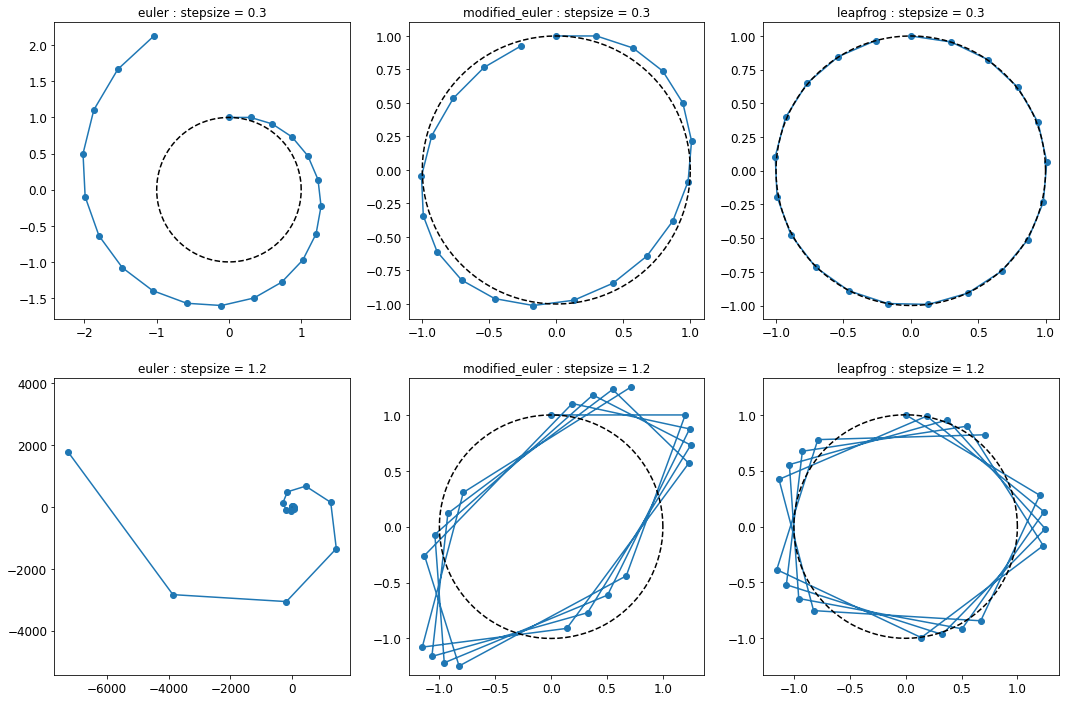

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

L = 20
for ax, epsilon, method in zip(
    axes.flatten(),
    [0.3, 0.3, 0.3, 1.2, 1.2, 1.2],
    ["euler", "modified_euler", "leapfrog", "euler", "modified_euler", "leapfrog"]
):
    solve_and_plot_trajectory(ax, q_initial, p_initial, q_exact, p_exact, grad_U, epsilon, L, method)

In the figure, shown in dashed curves are exact solutions, while shown in solid curves are numerical solutions.
It can be seen that

* Euler method is unstable, meaning the the solution diverges to infinity (Actually, at least for this example, it can be analytically proved that the method is unstable for any $\varepsilon > 0$.)
* Modified euler and leapfrog method are seem to be stable, but the latter performs better than the former. It can be shown that, for a single step, as $\varepsilon \rightarrow 0$, modified euler method has $\mathcal{O}(\varepsilon^2)$ error, while leapfrog method has $\mathcal{O}(\varepsilon^3)$.

It should be noted that leapfrog method is not always stable, as in the following example:

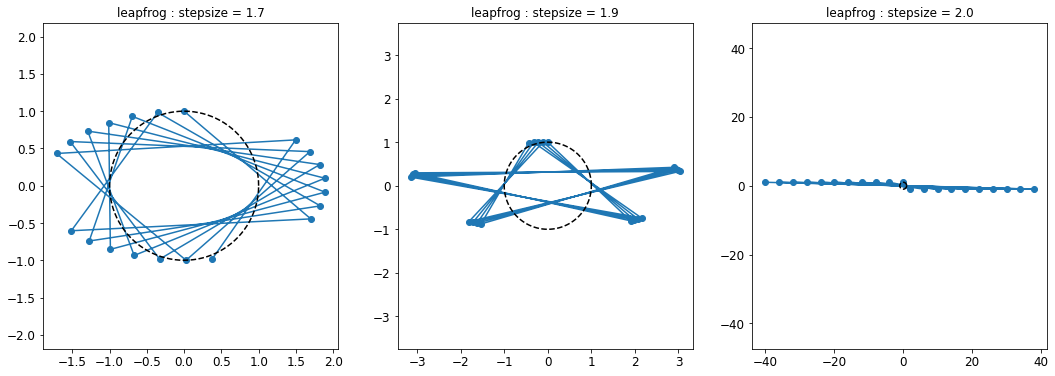

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

L = 20
method = "leapfrog"
for ax, epsilon in zip(
    axes.flatten(),
    [1.7, 1.9, 2.0],
):
    solve_and_plot_trajectory(ax, q_initial, p_initial, q_exact, p_exact, grad_U, epsilon, L, method)

## 2.2 Violation of Hamiltonian conservation

Although leapfrog method performs better than other methods shown above, it is not without numerically error. 
In HMC, this numerical error shows itself as non-zero rejection probability resulting from the violation of energy conservation, which are illustrated below.

In [7]:
def solve_and_plot_energy(ax, q_initial, p_initial, grad_U, epsilon, L, method):
    q_trajectory, p_trajectory = integrate_eqm(q_initial, p_initial, grad_U, epsilon, L, method=method)
    ax.plot(np.linspace(0, epsilon * L, L + 1), 0.5 * ((q_trajectory**2).sum(axis=1) +  (p_trajectory**2).sum(axis=1)), 'o-', label=f"epsilon={epsilon}")
    E0 = 0.5 * ((q_initial**2).sum() +  (p_initial**2).sum())
    ax.plot([0, epsilon * L], [E0, E0], '--', color='k')

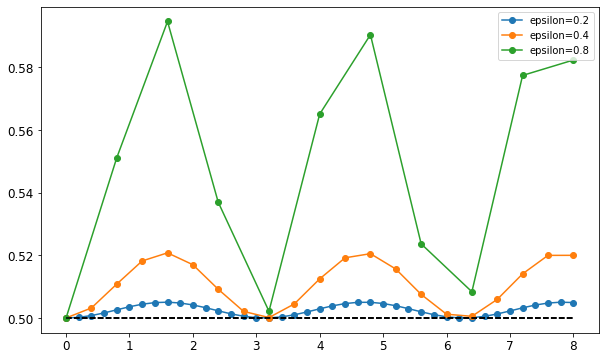

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for epsilon, L in zip([0.2, 0.4, 0.8], [40, 20, 10]):
    solve_and_plot_energy(ax, q_initial, p_initial, grad_U, epsilon, L, method="leapfrog")

ax.legend()
plt.show()

It can be seen that as the step size grows, so does the numerical fluctuation of Hamiltonian. 
When the stepsize is so large that the trajectory is not stable, Hamiltonian may indefinitely grow as follows, which causes acceptance probability in HMC extremely low:

Text(0.5, 1.0, 'energy')

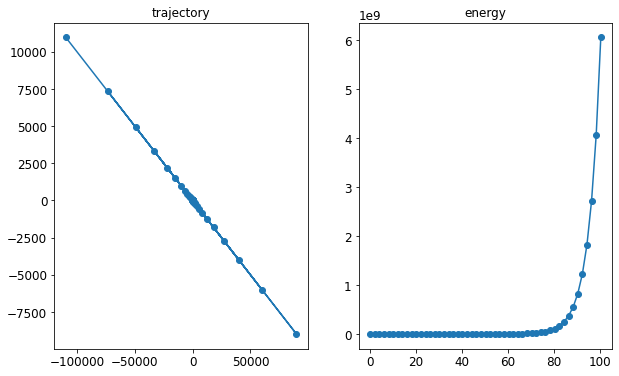

In [9]:
epsilon = 2.01
L = 50

q_trajectory, p_trajectory = integrate_eqm(q_initial, p_initial, grad_U, epsilon, L, method=method)
E = 0.5 * ((q_trajectory**2).sum(axis=1) +  (p_trajectory**2).sum(axis=1))

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(q_trajectory[:, 0], p_trajectory[:, 0], 'o-')
axes[0].set_title("trajectory")
axes[1].plot(np.linspace(0, epsilon * L, len(E)), E, 'o-')
axes[1].set_title("energy")

# 3 Code and experiment 2 : HMC sampling

## 3.1 Leapfrog method

In HMC, where we do not need the trajectory of $p$, the successive application of $h_{\varepsilon}$ can be simplified as follows:
$$
\begin{align}
    h_{\varepsilon} \circ h_{\varepsilon} = f_{\varepsilon} \circ g_{\varepsilon} \circ f_{\varepsilon}^{2} \circ g_{\varepsilon} \circ f_{\varepsilon}
\end{align}
$$
$$
\begin{align}
    f_{\varepsilon}^{2} \left(
        \begin{array}{c}
            q \\
            p
        \end{array}
    \right)
    = \left(
        \begin{array}{c}
            q \\
            p - \varepsilon \frac{\partial U}{\partial q}
        \end{array}
    \right)
\end{align}
$$

More concretely, 
$$
\begin{align}
    h_{\varepsilon}^{L} = f_{\varepsilon} \circ g_{\varepsilon} \circ \left( f_{\varepsilon}^{2} \circ g_{\varepsilon} \right)^{L-1} \circ f_{\varepsilon}
\end{align}
$$

In [10]:
def leapfrog(q_initial, p_initial, grad_U, epsilon, L):
    '''
    This is a function for integrating Hamiltonian equation of motion using leapfrog method.
    It only returns the value obtained at the end of trajectory.
    
    Parameters
    ----------
    q_initial : 1D numpy array
        1D numpy array representing the initial value of the position variable q.
    p_initial : 1D numpy array
        1D numpy array representing the initial value of the momentum variable p.
        len(p_initial) == len(q_initial) must holds
    grad_U : function
        A function, given position variable q, that returns the gradient of potential energy U.
    epsilon : float
        A positive real number representing the time step size
    L : int
        A positive integer representing the number of time steps
    
    Returns
    ----------
    q : 1D numpy array
        1D numpy array representing the final value of the position variable.
    p : 1D numpy array
        1D numpy array representing the final value of the momentum variable.
    '''
    
    q = q_initial
    p = p_initial
    
    p = p - epsilon / 2 * grad_U(q)  # f__{\varepsilon}
    for i in range(1, L):
        q = q + epsilon * p  # g_{\varepsilon}
        p = p - epsilon * grad_U(q)  # f_{\varepsilon}^{2}
        
    q = q + epsilon * p  # g_{\varepsilon}
    p = p - epsilon / 2 * grad_U(q)  # f__{\varepsilon}
    
    return q, p

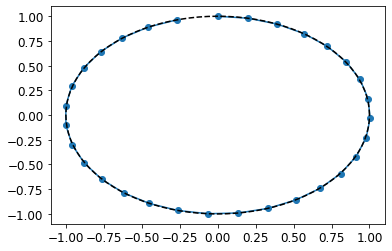

In [11]:
# for test

def grad_U(q):
    return q

q_initial = np.array([0.0])
p_initial = np.array([1.0])
epsilon = 0.2
L = 30

q_trajectory = np.zeros((L+1, len(q_initial)))
p_trajectory = np.zeros((L+1, len(p_initial)))

q = q_initial
p = p_initial
q_trajectory[0] = q
p_trajectory[0] = p

for l in range(1, L+1):
    q, p = leapfrog(q, p, grad_U, epsilon, 1)
    q_trajectory[l] = q
    p_trajectory[l] = p


plt.plot(q_trajectory[:, 0], p_trajectory[:, 0], 'o-')
q_exact = np.cos(np.linspace(0, 2*np.pi, 101))
p_exact = np.sin(np.linspace(0, 2*np.pi, 101))
plt.plot(q_exact, p_exact, "k--")
plt.show()

## 3.2 Sampler

With leapfrog method implemented above, the implementation of HMC is straightforward.

In [12]:
class HMCsampler:
    def __init__(self, dim, U, grad_U):
        self.dim = dim
        self.U = U
        self.grad_U = grad_U
        
    def _hamiltonian(self, q, p):
        return 0.5 * (p * p).sum() + U(q)
    
    def _update(self, q_current, epsilon, L):
        '''
        A method for performing a single HMC update. 
        
        Parameters
        ----------
        q_current: 1D array
            1D array representing the current value of the variable q.
        epsilon : float
            A positive real number representing the time step size
        L : int
            A positive integer representing the number of time steps
            
        Returns
        ----------
        q : 1D array
        '''
        # randomly sample momentum from \pi_{P}
        p_current = np.random.normal(size=self.dim)  
        
        # generate a proposal point by leapfrog method
        q_proposed, p_proposed = leapfrog(q_current, p_current, self.grad_U, epsilon, L)
        
        # determine accept/reject
        tmprand = np.random.random()
        if tmprand < np.exp(self._hamiltonian(q_current, p_current) - self._hamiltonian(q_proposed, p_proposed)):
            return q_proposed  # accept
        else:
            return q_current  # reject

        
    def sample(self, q_initial, n_samples, epsilon, L):
        '''
        A method for performing HMC sampling. 
        
        Parameters
        ----------
        q_initial : 1D array
            1D array representing the initial value of the variable q.
        n_samples : int
            An integer reprensenting the number of samples required.
        epsilon : float
            A positive real number representing the time step size
        L : int
            A positive integer representing the number of time steps
            
        Returns
        ----------
        Q : 2D array
            (n_samples, len(q_initial)) array storing samples
        '''
        
        Q = np.zeros((n_samples, self.dim))
        q_current = q_initial
        for i in range(n_samples):
            q_current = self._update(q_current, epsilon, L)
            Q[i] = q_current
        return Q

## 3.3 Experiment 

### 3.3.1 1D gaussian distribution

As a first set of experiments on HMC sampler, we shall sample from one dimensional gaussian distribution.

In [13]:
def U(q):
    return 0.5 * ((q**2).sum())

def grad_U(q):
    return q

hmc_1dgaussian = HMCsampler(dim=1, U=U, grad_U=grad_U)

In [14]:
def sample_hmc_1dgaussian(hmc, q_initial, n_samples, epsilon, L):
    # get the samples
    Q = hmc.sample(
        q_initial=q_initial,
        n_samples=n_samples,
        epsilon=epsilon,
        L=L
    )

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    # plot histogram
    ax = axes[0]
    ax.hist(Q, bins=np.arange(-3, 3, 0.2), density=True, label="Normalized histogram")
    xx = np.linspace(-3, 3, 100)
    ax.plot(xx, np.exp(-0.5*xx*xx)/(np.sqrt(2*np.pi)), label="probability density function")
    # plot time series of q
    axes[1].plot(Q[:, 0], '.')

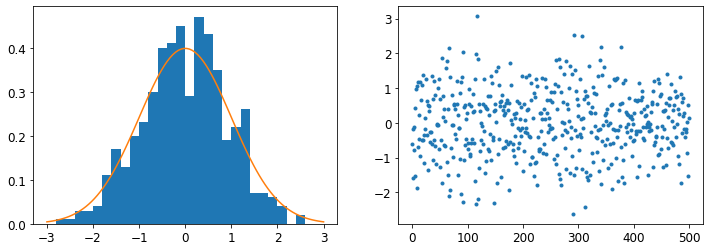

In [15]:
sample_hmc_1dgaussian(hmc_1dgaussian, q_initial=np.array([1.0]), n_samples=500, epsilon=0.3, L=13)

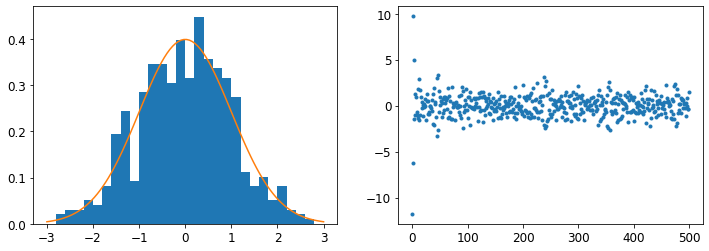

In [16]:
# neglecting samples obtained in early stage, it seems that HMC still works when it was started from a tail
sample_hmc_1dgaussian(hmc_1dgaussian, q_initial=np.array([15.0]), n_samples=500, epsilon=0.3, L=13)

The figures indicate that the sample obtained approximately follow the distribution form which we want to sample. 

However, if we choose inappropriate values of $\varepsilon$ and $L$, then the result gets odd.

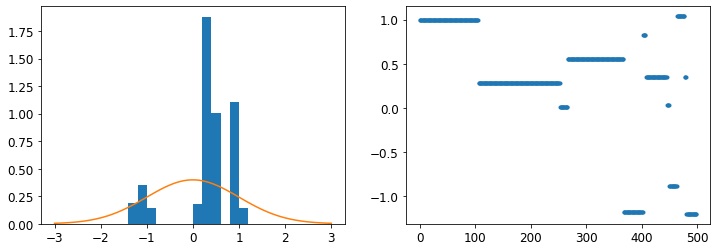

In [17]:
# too large epsilon, which makes Hamiltonian grows indefinitely, resulting in extremely low acceptance probability

sample_hmc_1dgaussian(hmc_1dgaussian, q_initial=np.array([1.0]), n_samples=500, epsilon=2.01, L=13)

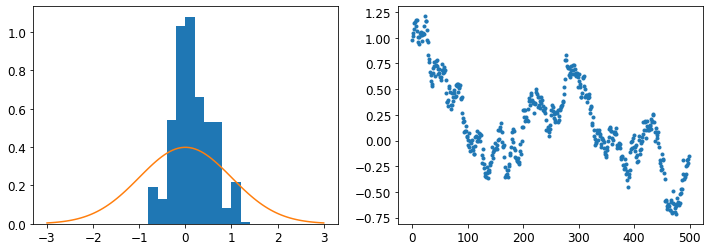

In [18]:
# Case where $\varepsilon L$ is the period of the trajectory determined by Hamiltonian
# In such case, the proposed point is expected to be close from the current point, which results in random-walk-like behavior.
sample_hmc_1dgaussian(hmc_1dgaussian, q_initial=np.array([1.0]), n_samples=500, epsilon=2*np.pi/13, L=13)

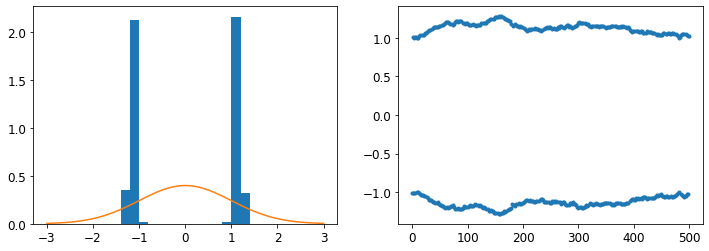

In [19]:
# Case where $\varepsilon L$ is the half of the period of the trajectory determined by Hamiltonian
# The point hops between two peaks.
sample_hmc_1dgaussian(hmc_1dgaussian, q_initial=np.array([1.0]), n_samples=500, epsilon=2*np.pi/(13*2), L=13)

### 3.3.2 1D gamma distribution

In [20]:
def U(q):
    assert len(q) == 1
    if q[0] <= 0:
        return np.float("inf")
    else:
        return -2 * np.log(q[0]) + q[0]

def grad_U(q):
    return 1 - 2/q

hmc_1dgamma = HMCsampler(dim=1, U=U, grad_U=grad_U)

In [21]:
def sample_hmc_1dgamma(hmc, q_initial, n_samples, epsilon, L):
    # get the samples
    Q = hmc.sample(
        q_initial=q_initial,
        n_samples=n_samples,
        epsilon=epsilon,
        L=L
    )

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    # plot histogram
    ax = axes[0]
    ax.hist(Q, bins=np.arange(0, 10, 0.2), density=True, label="Normalized histogram")
    xx = np.linspace(0, 10, 100)
    ax.plot(xx, 0.5*xx**2*np.exp(-xx), label="probability density function")
    # plot time series of q
    axes[1].plot(Q[:, 0], '.')

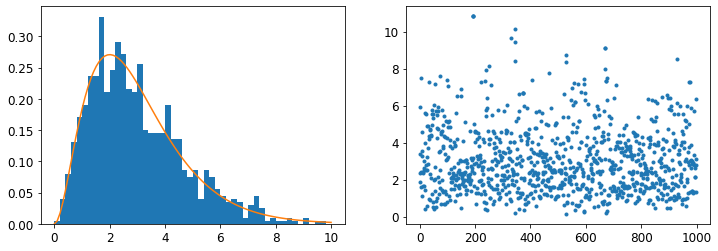

In [22]:
sample_hmc_1dgamma(hmc_1dgamma, q_initial=np.array([1.0]), n_samples=1000, epsilon=0.1, L=50)

### 3.3.3 2D Gaussian distribution